# 1D Wavelength Calibration Tutorial 3: Non-Interactive Fit

This notebook focuses on a **non-interactive workflow** for 1D wavelength calibration that is
particularly useful for **automated data reduction pipelines** where the instrument configuration
(spectrograph, grating/grism, approximate wavelength range) is well-characterized beforehand.

Instead of requiring manual identification of initial line pairs (as shown in Tutorials 1 and 2
using `WavelengthCalibration1D.fit_lines`), this workflow uses the
`WavelengthCalibration1D.fit_global` method. This method uses a global optimization algorithm to
determine the wavelength solution. It achieves this by automatically finding the best polynomial
coefficients that minimize the overall distance between detected arc lamp lines and a provided
catalog of theoretical line wavelengths.

A key requirement for `fit_global` is providing reasonable initial **bounds** for the wavelength
and dispersion (Å/pixel) at a chosen reference pixel. These bounds are derived from **prior
knowledge** of the instrument setup and guide the optimization search.

Like Tutorial 2, this example uses three arc lamp spectra (HgAr, Ne, Xe) obtained with the R1000R
 grism of the [Osiris spectrograph](https://www.gtc.iac.es/instruments/osiris/)  at the
 [Gran Telescopio Canarias (GTC)](https://www.gtc.iac.es/).

In [1]:
import astropy.units as u
import numpy as np

from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from matplotlib.pyplot import setp, subplots, close, rc

from specreduce.compat import Spectrum
from specreduce.wavecal1d import WavelengthCalibration1D

rc('figure', figsize=(15, 3))

## 1. Read Arc Spectra & Initialize Wavelength Solution Class

First, we load the data for the three arc lamps (HgAr, Ne, Xe) from the example FITS table `osiris_arcs.fits`. We create a list of `specutils.Spectrum` objects, one for each lamp.

Next, we prepare the corresponding line lists. For the HgAr lamp, we define a custom list as a NumPy array containing known air wavelengths specific to this GTC/OSIRIS setup, derived from the [official GTC line list](https://www.gtc.iac.es/instruments/osiris/media/lines/GTClinelist0.txt). For the Neon (Ne) and Xenon (Xe) lamps, we simply provide their standard identifiers (`'NeI'`, `'XeI'`) within lists. `WavelengthSolution1D` will use `specreduce.calibration_data.load_pypeit_calibration_lines` internally to fetch these standard lists.

Finally, we instantiate the `WavelengthSolution1D` class:
- `ref_pixel=1000`: Sets the reference pixel for the polynomial fit.
- `degree=4`: Specifies a 4th-degree polynomial for the pixel-to-wavelength model.
- `arc_spectra=arc_spectra`: Provides the list of `Spectrum` objects.
- `line_lists=[hgar_lines, ['NeI'], ['XeI']]`: Provides the list of corresponding line data (matching the order of `arc_spectra`). Note how we mix the custom array and lists of standard names.
- `line_list_bounds=(5100, 10000)`: Filters the line lists to include only lines within this approximate wavelength range (in Angstroms).
- `unit=u.angstrom`: Explicitly defines the wavelength unit.
- `wave_air=True`: Inform the class that the provided line lists (both custom and standard PypeIt lists for these lamps) contain **air** wavelengths. The class will handle conversions appropriately if needed for internal consistency or specific outputs, but the primary fitting coordinate system will be based on these air wavelengths.

In [2]:
lamps = 'HgAr', 'Ne', 'Xe'
hgar_lines = np.array([5460.735, 5769.598, 5790.663,  6965.431, 7272.936, 7635.106, 
                     7724.207, 7948.176, 8115.311, 8264.522, 9122.967])

tb = Table.read('osiris_arcs.fits')
arc_spectra = [Spectrum(flux=tb[f'{l}_flux'].value.astype('d')*u.DN, 
                         uncertainty=StdDevUncertainty(tb[f'{l}_err'].value.astype('d'))) 
                 for l in lamps]

ws = WavelengthCalibration1D(ref_pixel=1000,
                             degree=4,
                             arc_spectra=arc_spectra,
                             line_lists=[hgar_lines, ['NeI'], ['XeI']],
                             line_list_bounds=(5100, 10000),
                             unit=u.angstrom,
                             wave_air=True)

## 2. Perform Automated Fit using `fit_global`

With the `WavelengthSolution1D` object initialized, we proceed to calculate the wavelength solution automatically.

**Step 1: Find Lines**
We first execute `ws.find_lines()`. This step automatically detects emission lines in each of the input arc spectra (`arc_spectra`) and calculates their pixel centroids. These detected centroids are stored internally in `ws.observed_lines`. The `fwhm` (estimated line width in pixels) and `noise_factor` parameters help the algorithm distinguish real lines from noise; these may need tuning depending on the data quality.

**Step 2: Global Fit**
Next, the core of the non-interactive workflow: `ws.fit_global()`. This method initiates the global optimization search.
- **No Manual Input:** Notice we do *not* provide any specific pixel-wavelength pairs.
- **Bounds are Key:** Instead, we *must* provide `wavelength_bounds` and `dispersion_bounds`. These constrain the optimizer's search space for the polynomial coefficients. They represent our *a priori* knowledge about the instrument setup.
  - For this GTC/OSIRIS R1000R example, we know the approximate central wavelength is ~7430 Å and the dispersion near the center is ~2.62 Å/pixel. We provide bounds around these values: `wavelength_bounds=[7420, 7470]` Å and `dispersion_bounds=[2.5, 2.7]` Å/pixel.
- **Optimization Process:** The differential evolution algorithm searches for polynomial coefficients within these constraints (and broader limits for higher-order terms) that best map the detected `observed_lines` to the `catalog_lines` by minimizing the sum of distances to the nearest catalog neighbors (using internal KDTrees for efficiency).
- **Refinement:** We set `refine_fit=True`. After the global optimization finds an initial solution, this triggers an automatic call to `ws.refine_fit()`. This internal step uses the initial solution to explicitly match observed and catalog lines within a tolerance (`match_distance_bound`) and then performs a standard least-squares fit using *only* these matched pairs. This typically results in a higher-precision final solution.

**Step 3: Visualize Result**
We then call `ws.plot_fit()` to visualize the outcome. Because we provided multiple arc spectra, it generates pairs of plots for each frame (HgAr, Ne, Xe). The top plot shows the catalog lines, and the bottom plot shows the observed lines (and the spectrum itself) mapped onto the final derived wavelength scale (`obs_to_wav=True`). This allows a visual check of the alignment and fit quality across all input lamps.

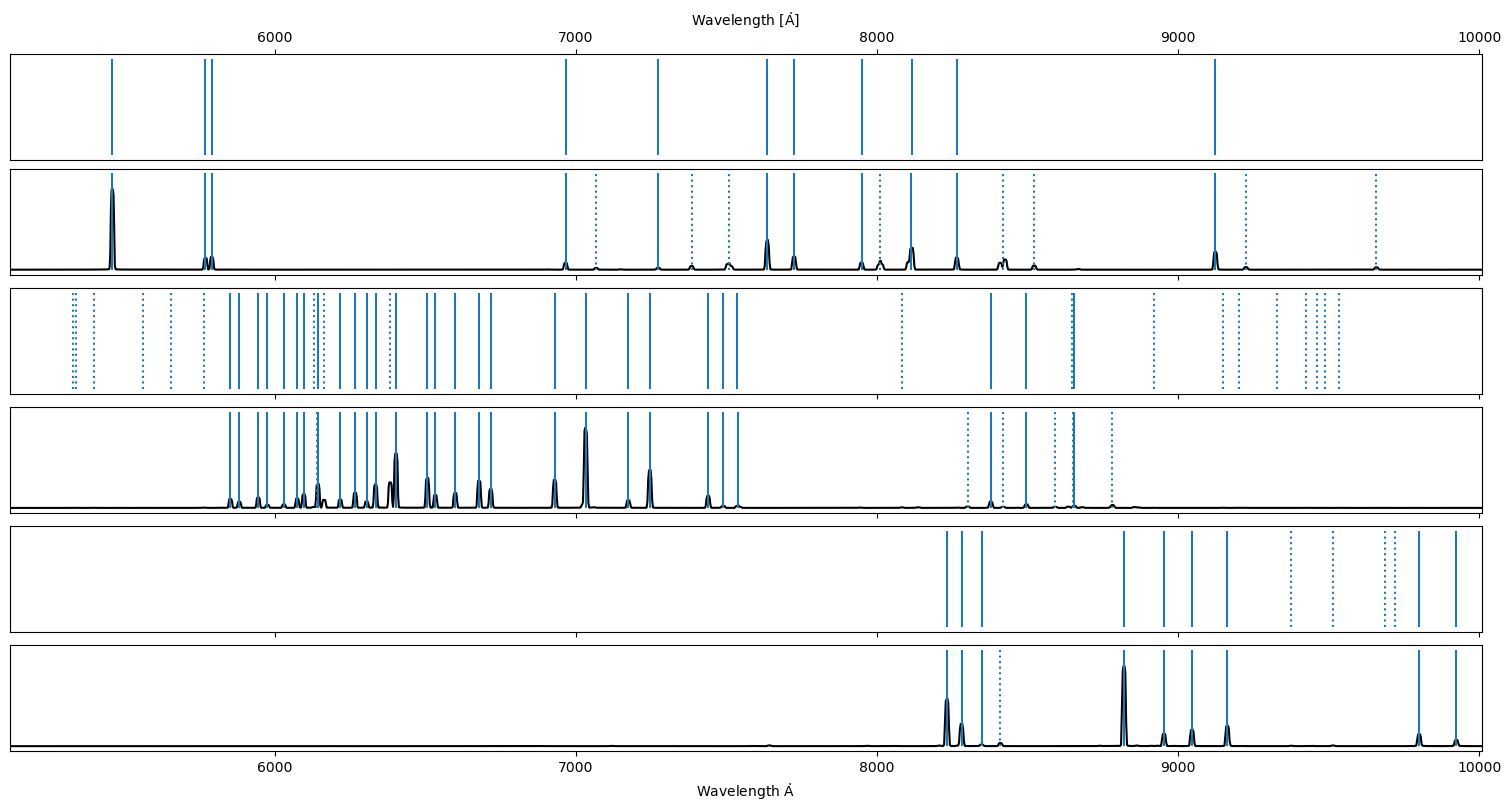

In [3]:
ws.find_lines(fwhm=4, noise_factor=15)

ws.fit_global(wavelength_bounds=[7420, 7470], 
              dispersion_bounds=[2.5, 2.7], 
              refine_fit=True)

ws.plot_fit(figsize=(15, 8), plot_values=False, obs_to_wav=True);

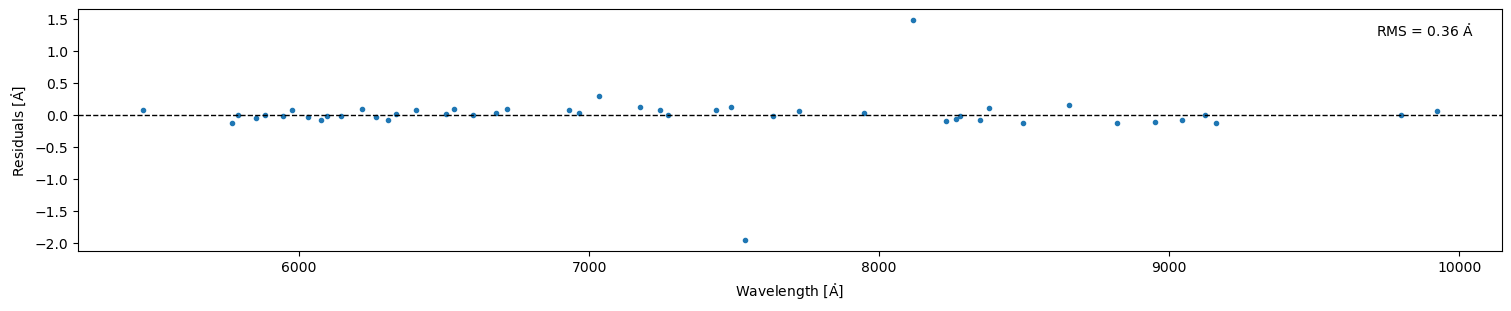

In [4]:
ws.plot_residuals(space='wavelength');

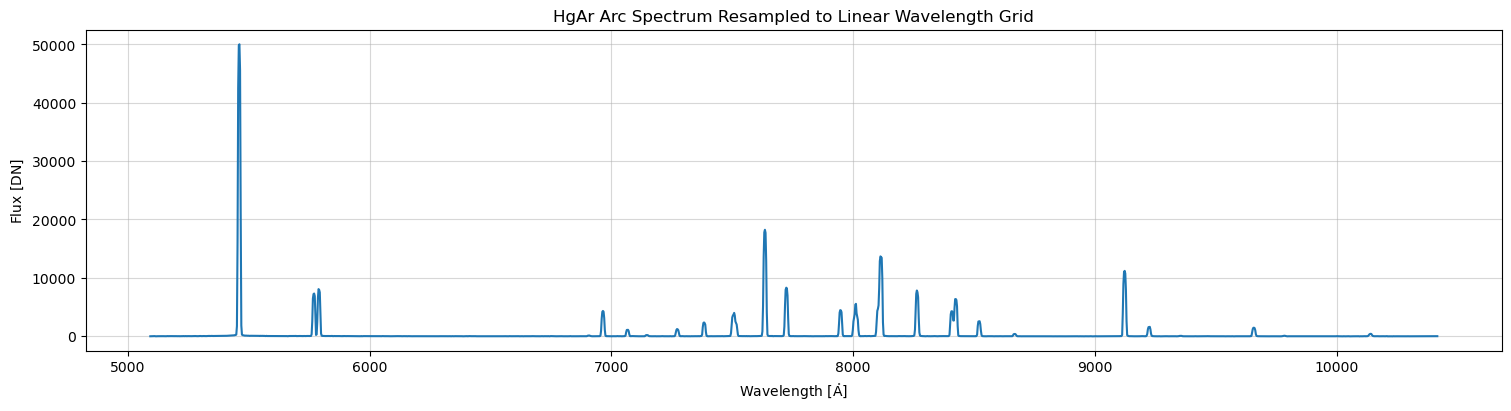

In [5]:
spectrum_wl = ws.resample(arc_spectra[0])

fig, ax = subplots(constrained_layout=True, figsize=(15, 4))
ax.plot(spectrum_wl.spectral_axis, spectrum_wl.flux)
ax.set_xlabel(f"Wavelength [{spectrum_wl.spectral_axis.unit.to_string('latex')}]")
ax.set_ylabel(f"Flux [{spectrum_wl.flux.unit.to_string('latex')}]")
ax.set_title("HgAr Arc Spectrum Resampled to Linear Wavelength Grid")
ax.grid(True, alpha=0.5)

In [11]:
np.diff(spectrum_wl.spectral_axis)

<SpectralAxis [2.59684021, 2.59684021, 2.59684021, ..., 2.59684021, 2.59684021,
   2.59684021] Angstrom>

In [6]:
spectrum_wl.flux.sum()

<Quantity 839275. DN>

In [8]:
arc_spectra[0].flux.sum()

<Quantity 839275. DN>

## 3. Accessing the WCS Object

Beyond resampling the flux array, the derived pixel-to-wavelength transformation is available as a standard [`gwcs`](https://gwcs.readthedocs.io/) (Generalized World Coordinate System) object via the `.wcs` property of the `WavelengthSolution1D` instance.

This WCS object encapsulates the fitted model (`ws._p2w`) and defines the mapping between the input pixel coordinate frame and the output spectral coordinate frame (including units).

**Uses:**
- **Applying the solution without rebinning:** You can use the WCS object directly with tools that understand GWCS (like `specutils`) to work with spectra while keeping the original pixel grid.
- **Interoperability:** Provides a standard way to represent the wavelength solution that can be understood by other Astropy-affiliated packages.
- **FITS Headers:** The GWCS object can be used to generate standard WCS keywords for inclusion in FITS file headers, making the wavelength calibration self-describing.

In [6]:
spectrum_wl.spectral_axis

<SpectralAxis [ 5095.00884974,  5097.6018222 ,  5100.19479466, ..., 10405.41645236,
   10408.00942482, 10410.60239729] Angstrom>

In [7]:
ws.wcs

<WCS(output_frame=SpectralFrame, input_frame=CoordinateFrame, forward_transform=Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] | [1]
Components: 
    [0]: <Shift(offset=-1000.)>

    [1]: <Polynomial1D(4, c0=7454.43205491, c1=2.63572601, c2=0.0002197, c3=-0.00000005, c4=0.)>
Parameters:
    offset_0        c0_1       ...           c3_1                   c4_1        
    -------- ----------------- ... ----------------------- ---------------------
     -1000.0 7454.432054908556 ... -5.0351299187468156e-08 4.958031715494442e-12)>

In [8]:
ws.wcs.pixel_to_world([100, 101])

<SpectralCoord [5300.19226793, 5302.29610776] Angstrom>

---